# Summary

Model parameters summary:

Hook in the last dropout layer

-   **drop_block: true**
-   **dropblock_prob: 0.5**
-   **dropblock_block_size: 6**
-   **dropout: true**
-   **dropout_prob: 0.3**
-   model_name: resnet18
-   input_channels: 3
-   spectral_norm: false
-   lr: 0.0001
-   weight_decay: 0.0001
-   loss_type: focal

**Results:**

Experiment: gtsrb vs gtsrb-anomal 

- AUROC: 0.8130
- FPR95: 0.6794
- AUPR: 0.8015

Experiment: gtsrb vs cifar10

- AUROC: 0.9673
- FPR95: 0.1992
- AUPR: 0.9334

Experiment: gtsrb vs stl10

- AUROC: 0.9845
- FPR95: 0.0603
- AUPR: 0.9777

# General Imports

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
%matplotlib inline

In [3]:
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import seaborn as sns
from PIL import Image
from icecream import ic

In [4]:
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchvision import transforms as transform_lib
from pytorch_lightning.callbacks import TQDMProgressBar
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [5]:
from datasets import GtsrbModule

In [6]:
from pl_bolts.datamodules import CIFAR10DataModule
from pl_bolts.datamodules import STL10DataModule

In [7]:
from models import ResnetModule

In [8]:
from dropblock import DropBlock2D, LinearScheduler

In [9]:
from ls_ood_detect_cea.uncertainty_estimation import Hook
from ls_ood_detect_cea.uncertainty_estimation import deeplabv3p_get_ls_mcd_samples
from ls_ood_detect_cea.uncertainty_estimation import get_latent_represent_mcd_samples
from ls_ood_detect_cea.uncertainty_estimation import get_dl_h_z
from ls_ood_detect_cea.ood_detection_dataset import build_ood_detection_ds
from ls_ood_detect_cea.dimensionality_reduction import plot_samples_pacmap
from ls_ood_detect_cea.detectors import KDEClassifier, DetectorKDE
from ls_ood_detect_cea.score import get_hz_scores
from ls_ood_detect_cea.metrics import get_hz_detector_results
from ls_ood_detect_cea.metrics import get_ood_detector_results
from ls_ood_detect_cea.metrics import plot_roc_ood_detector
from ls_ood_detect_cea.metrics import plot_auprc_ood_detector
from ls_ood_detect_cea.dimensionality_reduction import plot_samples_pacmap
from ls_ood_detect_cea.dimensionality_reduction import apply_pca_ds_split
from ls_ood_detect_cea.dimensionality_reduction import apply_pca_transform

# Paths

Datasets paths:

In [10]:
gtsrb_dataset_path = "/media/farnez/Data/DATASETS/gtsrb-data/"
cifar10_data_path = "/media/farnez/Data/DATASETS/cifar-10/"
stl10_data_path = "/media/farnez/Data/DATASETS/stl-10/"

Experiments path:

In [11]:
exp_path = "/media/farnez/Data/EXPERIMENTS/CVPR-2024/gtsrb-classification/"

Resnet Classification Model Number & checkpoint:

In [12]:
exp_model_name = "resnet18_model_11"

In [13]:
gtsrb_resnet18_model_path = exp_path + exp_model_name + "/model/epoch=1101-step=154280.ckpt"
gtsrb_resnet18_model_path

'/media/farnez/Data/EXPERIMENTS/CVPR-2024/gtsrb-classification/resnet18_model_11/model/epoch=1101-step=154280.ckpt'

Samples Paths:

In [14]:
mc_samples_path = exp_path + exp_model_name + "/embeddings_z/mc_samples/"
mc_samples_path

'/media/farnez/Data/EXPERIMENTS/CVPR-2024/gtsrb-classification/resnet18_model_11/embeddings_z/mc_samples/'

In [15]:
h_z_path = exp_path + exp_model_name + "/embeddings_z/entropy/"
h_z_path

'/media/farnez/Data/EXPERIMENTS/CVPR-2024/gtsrb-classification/resnet18_model_11/embeddings_z/entropy/'

# Compute Device

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Load Entropy Values

In [17]:
gtsrb_rn18_h_z_gtsrb_normal_train_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_gtsrb_normal_train_samples_np.npy')
gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np.npy')
gtsrb_rn18_h_z_gtsrb_normal_test_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_gtsrb_normal_test_samples_np.npy')

gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np.npy')
gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np.npy')

gtsrb_rn18_h_z_cifar10_valid_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_cifar10_valid_samples_np.npy')
gtsrb_rn18_h_z_cifar10_test_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_cifar10_test_samples_np.npy')

gtsrb_rn18_h_z_stl10_valid_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_stl10_valid_samples_np.npy')
gtsrb_rn18_h_z_stl10_test_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_stl10_test_samples_np.npy')

In [18]:
ic(gtsrb_rn18_h_z_gtsrb_normal_train_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_normal_test_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np.shape);
ic(gtsrb_rn18_h_z_cifar10_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_cifar10_test_samples_np.shape);
ic(gtsrb_rn18_h_z_stl10_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_stl10_test_samples_np.shape);

ic| gtsrb_rn18_h_z_gtsrb_normal_train_samples_np.shape: (7120, 512)
ic| gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np.shape: (3609, 512)
ic| gtsrb_rn18_h_z_gtsrb_normal_test_samples_np.shape: (1273, 512)
ic| gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np.shape: (3609, 512)
ic| gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np.shape: (1273, 512)
ic| gtsrb_rn18_h_z_cifar10_valid_samples_np.shape: (10000, 512)
ic| gtsrb_rn18_h_z_cifar10_test_samples_np.shape: (10000, 512)
ic| gtsrb_rn18_h_z_stl10_valid_samples_np.shape: (3000, 512)
ic| gtsrb_rn18_h_z_stl10_test_samples_np.shape: (8000, 512)


# LaRED Score - Train Data Reference

In [23]:
ic(gtsrb_rn18_h_z_gtsrb_normal_train_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_normal_test_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np.shape);
ic(gtsrb_rn18_h_z_cifar10_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_cifar10_test_samples_np.shape);
ic(gtsrb_rn18_h_z_stl10_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_stl10_test_samples_np.shape);

ic| gtsrb_rn18_h_z_gtsrb_normal_train_samples_np.shape: (7120, 512)


ic| gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np.shape: (3609, 512)
ic| gtsrb_rn18_h_z_gtsrb_normal_test_samples_np.shape: (1273, 512)
ic| gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np.shape: (3609, 512)
ic| gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np.shape: (1273, 512)
ic| gtsrb_rn18_h_z_cifar10_valid_samples_np.shape: (10000, 512)
ic| gtsrb_rn18_h_z_cifar10_test_samples_np.shape: (10000, 512)
ic| gtsrb_rn18_h_z_stl10_valid_samples_np.shape: (3000, 512)
ic| gtsrb_rn18_h_z_stl10_test_samples_np.shape: (8000, 512)


In [24]:
gtsrb_h_z = np.concatenate((gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np, gtsrb_rn18_h_z_gtsrb_normal_test_samples_np))
gtsrb_anomal_h_z = np.concatenate((gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np, gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np))
cifar10_h_z = np.concatenate((gtsrb_rn18_h_z_cifar10_valid_samples_np, gtsrb_rn18_h_z_cifar10_test_samples_np))
stl10_h_z = np.concatenate((gtsrb_rn18_h_z_stl10_valid_samples_np, gtsrb_rn18_h_z_stl10_test_samples_np))

## Build Detector

In [25]:
gtsrb_ds_shift_detector = DetectorKDE(train_embeddings=gtsrb_rn18_h_z_gtsrb_normal_train_samples_np)

## Get Scores

In [26]:
scores_gtsrb = get_hz_scores(gtsrb_ds_shift_detector, gtsrb_h_z)

scores_gtsrb_anomal = get_hz_scores(gtsrb_ds_shift_detector, gtsrb_anomal_h_z)

scores_cifar10 = get_hz_scores(gtsrb_ds_shift_detector, cifar10_h_z)

scores_stl10 = get_hz_scores(gtsrb_ds_shift_detector, stl10_h_z)

## Get Results

In [27]:
print("Test InD shape", scores_gtsrb.shape);
print("Test OoD shape", scores_gtsrb_anomal.shape);
print("Experiment: gtsrb vs gtsrb-anomal");


results_gtsrb_anomal_validation = get_hz_detector_results(detect_exp_name="gtsrb vs. gtsrb-anomal",
                                                          ind_samples_scores=scores_gtsrb,
                                                          ood_samples_scores=scores_gtsrb_anomal)

Test InD shape (4882,)
Test OoD shape (4882,)
Experiment: gtsrb vs gtsrb-anomal
AUROC: 0.5939
FPR95: 0.6452
AUPR: 0.5394


In [28]:
print("Test InD shape", scores_gtsrb.shape);
print("Test OoD shape", scores_cifar10.shape);
print("Experiment: gtsrb vs cifar10");

results_cifar10_validation = get_hz_detector_results(detect_exp_name="gtsrb vs. cifar10",
                                                     ind_samples_scores=scores_gtsrb,
                                                     ood_samples_scores=scores_cifar10)

Test InD shape (4882,)
Test OoD shape (20000,)
Experiment: gtsrb vs cifar10
AUROC: 0.6342
FPR95: 0.4895
AUPR: 0.2408


In [29]:
print("Test InD shape", scores_gtsrb.shape);
print("Test OoD shape", scores_stl10.shape);
print("Experiment: gtsrb vs stl10");

results_stl10_validation = get_hz_detector_results(detect_exp_name="gtsrb vs. stl10",
                                                   ind_samples_scores=scores_gtsrb,
                                                   ood_samples_scores=scores_stl10)

Test InD shape (4882,)
Test OoD shape (11000,)
Experiment: gtsrb vs stl10
AUROC: 0.6291
FPR95: 0.4985
AUPR: 0.3637


## Plot Score Values

In [30]:
df_scores_gtsrb = pd.DataFrame(scores_gtsrb, columns=["Entropy score"])
df_scores_gtsrb_anomal = pd.DataFrame(scores_gtsrb_anomal, columns=["Entropy score"])
df_scores_stl10 = pd.DataFrame(scores_stl10, columns=["Entropy score"])
df_scores_cifar10 = pd.DataFrame(scores_cifar10, columns=["Entropy score"])

df_scores_gtsrb.insert(0, "Dataset", "")
df_scores_gtsrb.loc[:, "Dataset"] = "gtsrb"

df_scores_gtsrb_anomal.insert(0, "Dataset", "")
df_scores_gtsrb_anomal.loc[:, "Dataset"] = "gtsrb-anomal"

df_scores_stl10.insert(0, "Dataset", "")
df_scores_stl10.loc[:, "Dataset"] = "stl10"

df_scores_cifar10.insert(0, "Dataset", "")
df_scores_cifar10.loc[:, "Dataset"] = "cifar10"

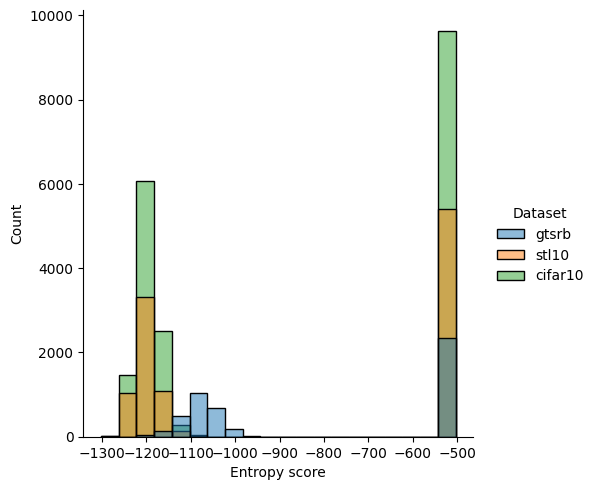

In [31]:
df_h_z_valid_scores = pd.concat([df_scores_gtsrb,
                                 df_scores_stl10,
                                 df_scores_cifar10]).reset_index(drop=True)

sns.displot(df_h_z_valid_scores, x="Entropy score", hue="Dataset", kind="hist", fill=True)
plt.show()

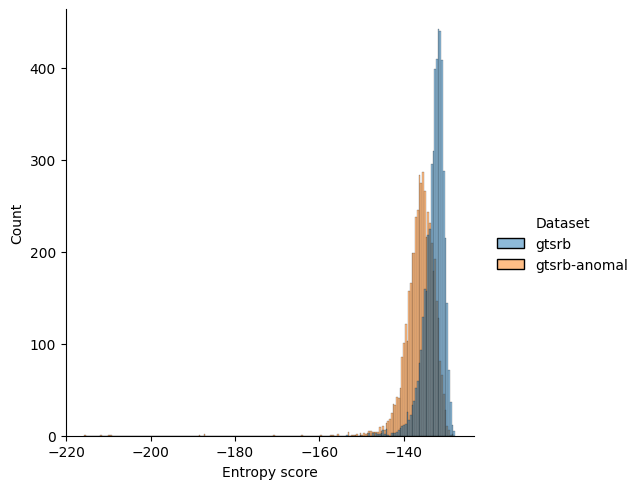

In [29]:
df_h_z_valid_scores = pd.concat([df_scores_gtsrb,
                                 df_scores_gtsrb_anomal]).reset_index(drop=True)

sns.displot(df_h_z_valid_scores, x="Entropy score", hue="Dataset", kind="hist", fill=True)
plt.show()

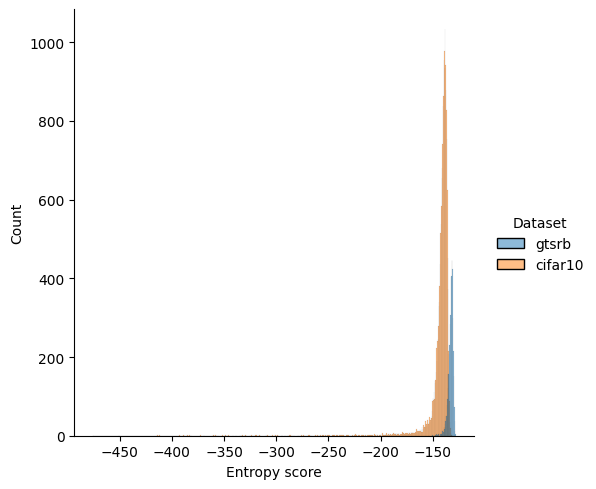

In [27]:
df_h_z_valid_scores = pd.concat([df_scores_gtsrb,
                                 df_scores_cifar10]).reset_index(drop=True)

sns.displot(df_h_z_valid_scores, x="Entropy score", hue="Dataset", kind="hist", fill=True)
plt.show()

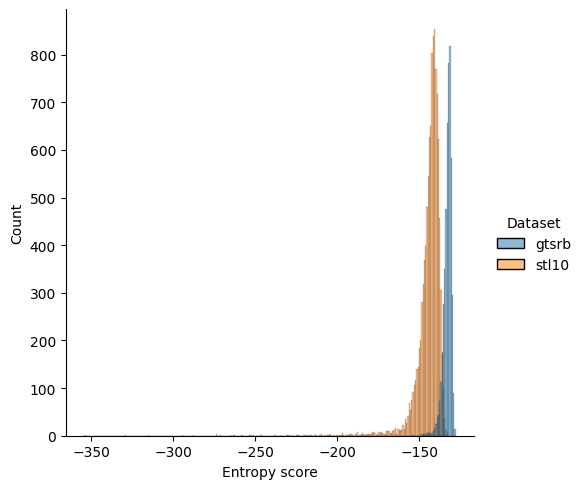

In [28]:
df_h_z_valid_scores = pd.concat([df_scores_gtsrb,
                                 df_scores_stl10]).reset_index(drop=True)

sns.displot(df_h_z_valid_scores, x="Entropy score", hue="Dataset", kind="hist", fill=True)
plt.show()

# Load Entropy Values

In [17]:
gtsrb_rn18_h_z_gtsrb_normal_train_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_gtsrb_normal_train_samples_np.npy')
gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np.npy')
gtsrb_rn18_h_z_gtsrb_normal_test_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_gtsrb_normal_test_samples_np.npy')

gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np.npy')
gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np.npy')

gtsrb_rn18_h_z_cifar10_valid_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_cifar10_valid_samples_np.npy')
gtsrb_rn18_h_z_cifar10_test_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_cifar10_test_samples_np.npy')

gtsrb_rn18_h_z_stl10_valid_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_stl10_valid_samples_np.npy')
gtsrb_rn18_h_z_stl10_test_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_stl10_test_samples_np.npy')

In [18]:
ic(gtsrb_rn18_h_z_gtsrb_normal_train_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_normal_test_samples_np.shape);

ic(gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np.shape);

ic(gtsrb_rn18_h_z_cifar10_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_cifar10_test_samples_np.shape);

ic(gtsrb_rn18_h_z_stl10_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_stl10_test_samples_np.shape);

ic| gtsrb_rn18_h_z_gtsrb_normal_train_samples_np.shape: (7120, 512)
ic| gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np.shape: (3609, 512)
ic| gtsrb_rn18_h_z_gtsrb_normal_test_samples_np.shape: (1273, 512)
ic| gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np.shape: (3609, 512)
ic| gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np.shape: (1273, 512)
ic| gtsrb_rn18_h_z_cifar10_valid_samples_np.shape: (10000, 512)
ic| gtsrb_rn18_h_z_cifar10_test_samples_np.shape: (10000, 512)
ic| gtsrb_rn18_h_z_stl10_valid_samples_np.shape: (3000, 512)
ic| gtsrb_rn18_h_z_stl10_test_samples_np.shape: (8000, 512)


# LaRED Score - Train Data Reference Dimensionalitty Reduction PCA

In [87]:
pca_gtsrb_rn18_h_z_gtsrb_normal_train_samples_np, pca_tr = apply_pca_ds_split(samples=gtsrb_rn18_h_z_gtsrb_normal_train_samples_np,
                                                                              nro_components=66)

In [88]:
pca_gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np = apply_pca_transform(gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np, pca_tr) # InD
pca_gtsrb_rn18_h_z_gtsrb_normal_test_samples_np = apply_pca_transform(gtsrb_rn18_h_z_gtsrb_normal_test_samples_np, pca_tr) # InD

pca_gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np = apply_pca_transform(gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np, pca_tr) # OoD | shifted
pca_gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np = apply_pca_transform(gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np, pca_tr) # OoD | shifted

pca_gtsrb_rn18_h_z_cifar10_valid_samples_np = apply_pca_transform(gtsrb_rn18_h_z_cifar10_valid_samples_np, pca_tr) # OoD | shifted
pca_gtsrb_rn18_h_z_cifar10_test_samples_np = apply_pca_transform(gtsrb_rn18_h_z_cifar10_test_samples_np, pca_tr) # OoD | shifted

pca_gtsrb_rn18_h_z_stl10_valid_samples_np = apply_pca_transform(gtsrb_rn18_h_z_stl10_valid_samples_np, pca_tr) # OoD | shifted
pca_gtsrb_rn18_h_z_stl10_test_samples_np = apply_pca_transform(gtsrb_rn18_h_z_stl10_test_samples_np, pca_tr) # OoD | shifted

In [89]:
ic(pca_gtsrb_rn18_h_z_gtsrb_normal_train_samples_np.shape);
ic(pca_gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np.shape);
ic(pca_gtsrb_rn18_h_z_gtsrb_normal_test_samples_np.shape);

ic(pca_gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np.shape);
ic(pca_gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np.shape);

ic(pca_gtsrb_rn18_h_z_cifar10_valid_samples_np.shape);
ic(pca_gtsrb_rn18_h_z_cifar10_test_samples_np.shape);

ic(pca_gtsrb_rn18_h_z_stl10_valid_samples_np.shape);
ic(pca_gtsrb_rn18_h_z_stl10_test_samples_np.shape);

ic| pca_gtsrb_rn18_h_z_gtsrb_normal_train_samples_np.shape: (7120, 66)
ic| pca_gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np.shape: (3609, 66)
ic| pca_gtsrb_rn18_h_z_gtsrb_normal_test_samples_np.shape: (1273, 66)
ic| pca_gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np.shape: (3609, 66)
ic| pca_gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np.shape: (1273, 66)
ic| pca_gtsrb_rn18_h_z_cifar10_valid_samples_np.shape: (10000, 66)
ic| pca_gtsrb_rn18_h_z_cifar10_test_samples_np.shape: (10000, 66)
ic| pca_gtsrb_rn18_h_z_stl10_valid_samples_np.shape: (3000, 66)


ic| pca_gtsrb_rn18_h_z_stl10_test_samples_np.shape: (8000, 66)


In [90]:
pca_gtsrb_rn18_ind_gtsrb_normal_samples = np.concatenate((pca_gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np,
                                                          pca_gtsrb_rn18_h_z_gtsrb_normal_test_samples_np))

pca_gtsrb_rn18_ood_gtsrb_anomal_samples = np.concatenate((pca_gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np,
                                                          pca_gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np))

pca_gtsrb_rn18_ood_cifa10_samples = np.concatenate((pca_gtsrb_rn18_h_z_cifar10_valid_samples_np,
                                                    pca_gtsrb_rn18_h_z_cifar10_test_samples_np))

pca_gtsrb_rn18_ood_stl10_samples = np.concatenate((pca_gtsrb_rn18_h_z_stl10_valid_samples_np,
                                                   pca_gtsrb_rn18_h_z_stl10_test_samples_np))

ic(pca_gtsrb_rn18_ind_gtsrb_normal_samples.shape);
ic(pca_gtsrb_rn18_ood_gtsrb_anomal_samples.shape);
ic(pca_gtsrb_rn18_ood_cifa10_samples.shape);
ic(pca_gtsrb_rn18_ood_stl10_samples.shape);

ic| pca_gtsrb_rn18_ind_gtsrb_normal_samples.shape: (4882, 66)
ic| pca_gtsrb_rn18_ood_gtsrb_anomal_samples.shape: (4882, 66)
ic| pca_gtsrb_rn18_ood_cifa10_samples.shape: (20000, 66)
ic| pca_gtsrb_rn18_ood_stl10_samples.shape: (11000, 66)


## Build Detector

In [91]:
gtsrb_rn18_ds_shift_detector_pca = DetectorKDE(train_embeddings=pca_gtsrb_rn18_h_z_gtsrb_normal_train_samples_np)

## Get Scores

In [92]:
scores_pca_gtsrb_rn18_ind_gtsrb_normal_h_z = get_hz_scores(gtsrb_rn18_ds_shift_detector_pca,
                                                           pca_gtsrb_rn18_ind_gtsrb_normal_samples)

scores_pca_gtsrb_rn18_ood_gtsrb_anomal_h_z = get_hz_scores(gtsrb_rn18_ds_shift_detector_pca,
                                                           pca_gtsrb_rn18_ood_gtsrb_anomal_samples)

scores_pca_gtsrb_rn18_ood_cifa10_h_z = get_hz_scores(gtsrb_rn18_ds_shift_detector_pca,
                                                     pca_gtsrb_rn18_ood_cifa10_samples)

scores_pca_gtsrb_rn18_ood_stl10_h_z = get_hz_scores(gtsrb_rn18_ds_shift_detector_pca,
                                                    pca_gtsrb_rn18_ood_stl10_samples)

## Get Results

In [93]:
print("PCA Components: ", pca_gtsrb_rn18_h_z_gtsrb_normal_train_samples_np.shape[1])

print("\ngtsrb-normal vs. gtsrb-anomal:")
print("Test InD shape", scores_pca_gtsrb_rn18_ind_gtsrb_normal_h_z.shape);
print("Test OoD shape", scores_pca_gtsrb_rn18_ood_gtsrb_anomal_h_z.shape);

results_gtsrb_anomal = get_hz_detector_results(detect_exp_name="woodscape-normal vs. wooscape-anomal",
                                               ind_samples_scores=scores_pca_gtsrb_rn18_ind_gtsrb_normal_h_z,
                                               ood_samples_scores=scores_pca_gtsrb_rn18_ood_gtsrb_anomal_h_z)

print("\ngtsrb-normal vs. cifar10:")
print("Test InD shape", scores_pca_gtsrb_rn18_ind_gtsrb_normal_h_z.shape);
print("Test OoD shape", scores_pca_gtsrb_rn18_ood_cifa10_h_z.shape);

results_cifar10 = get_hz_detector_results(detect_exp_name="woodscape-normal vs. cityscapes",
                                          ind_samples_scores=scores_pca_gtsrb_rn18_ind_gtsrb_normal_h_z,
                                          ood_samples_scores=scores_pca_gtsrb_rn18_ood_cifa10_h_z)

print("\ngtsrb-normal vs. stl10:")
print("Test InD shape", scores_pca_gtsrb_rn18_ind_gtsrb_normal_h_z.shape);
print("Test OoD shape", scores_pca_gtsrb_rn18_ood_stl10_h_z.shape);

results_stl10 = get_hz_detector_results(detect_exp_name="woodscape-normal vs. woodscape-soiling",
                                        ind_samples_scores=scores_pca_gtsrb_rn18_ind_gtsrb_normal_h_z,
                                        ood_samples_scores=scores_pca_gtsrb_rn18_ood_stl10_h_z)

PCA Components:  66

gtsrb-normal vs. gtsrb-anomal:
Test InD shape (4882,)
Test OoD shape (4882,)
AUROC: 0.6987
FPR95: 0.8400
AUPR: 0.7112

gtsrb-normal vs. cifar10:
Test InD shape (4882,)
Test OoD shape (20000,)
AUROC: 0.7646
FPR95: 0.7685
AUPR: 0.5822

gtsrb-normal vs. stl10:
Test InD shape (4882,)
Test OoD shape (11000,)
AUROC: 0.7689
FPR95: 0.7575
AUPR: 0.6868


**Best Results:**

PCA Components:  28

gtsrb-normal vs. gtsrb-anomal:
- AUROC: 0.8017
- FPR95: 0.7120
- AUPR: 0.7772


gtsrb-normal vs. cifar10:
- AUROC: 0.8720
- FPR95: 0.6807
- AUPR: 0.7527


gtsrb-normal vs. stl10:
- AUROC: 0.8759
- FPR95: 0.6815
- AUPR: 0.8270

# Load Entropy Values

In [46]:
gtsrb_rn18_h_z_gtsrb_normal_train_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_gtsrb_normal_train_samples_np.npy')
gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np.npy')
gtsrb_rn18_h_z_gtsrb_normal_test_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_gtsrb_normal_test_samples_np.npy')

gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np.npy')
gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np.npy')

gtsrb_rn18_h_z_cifar10_valid_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_cifar10_valid_samples_np.npy')
gtsrb_rn18_h_z_cifar10_test_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_cifar10_test_samples_np.npy')

gtsrb_rn18_h_z_stl10_valid_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_stl10_valid_samples_np.npy')
gtsrb_rn18_h_z_stl10_test_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_stl10_test_samples_np.npy')

# LaREM Score

In [48]:
ic(gtsrb_rn18_h_z_gtsrb_normal_train_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_normal_test_samples_np.shape);

ic(gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np.shape);

ic(gtsrb_rn18_h_z_cifar10_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_cifar10_test_samples_np.shape);

ic(gtsrb_rn18_h_z_stl10_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_stl10_test_samples_np.shape);

ic| gtsrb_rn18_h_z_gtsrb_normal_train_samples_np.shape: (7120, 512)
ic| gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np.shape: (3609, 512)
ic| gtsrb_rn18_h_z_gtsrb_normal_test_samples_np.shape: (1273, 512)
ic| gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np.shape: (3609, 512)
ic| gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np.shape: (1273, 512)
ic| gtsrb_rn18_h_z_cifar10_valid_samples_np.shape: (10000, 512)
ic| gtsrb_rn18_h_z_cifar10_test_samples_np.shape: (10000, 512)
ic| gtsrb_rn18_h_z_stl10_valid_samples_np.shape: (3000, 512)
ic| gtsrb_rn18_h_z_stl10_test_samples_np.shape: (8000, 512)


In [49]:
gtsrb_h_z = np.concatenate((gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np, gtsrb_rn18_h_z_gtsrb_normal_test_samples_np))
gtsrb_anomal_h_z = np.concatenate((gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np, gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np))
cifar10_h_z = np.concatenate((gtsrb_rn18_h_z_cifar10_valid_samples_np, gtsrb_rn18_h_z_cifar10_test_samples_np))
stl10_h_z = np.concatenate((gtsrb_rn18_h_z_stl10_valid_samples_np, gtsrb_rn18_h_z_stl10_test_samples_np))

## Build LaREM Distribution Shift Detector

In [50]:
from sklearn.covariance import EmpiricalCovariance

class LaREMPostprocessor:
    def __init__(self,
                 setup_flag: bool = False,
                 get_2d_rep_mean: bool = False):

        self.setup_flag = setup_flag
        self.get_2d_rep_mean = get_2d_rep_mean
        self.feats_mean = None
        self.precision = None

    def setup(self,
              ind_feats: np.ndarray):
        
        if not self.setup_flag:
            # estimate mean and variance from training set
            print('\n Estimating mean and variance from training set...')

            self.feats_mean = ind_feats.mean(0)
            self.feats_mean = np.mean(ind_feats, 0, keepdims=True)
            
            self.centered_data = ind_feats - self.feats_mean
              
            group_lasso = EmpiricalCovariance(assume_centered=False)
            group_lasso.fit(self.centered_data)
            
            self.precision = group_lasso.precision_
            
            self.setup_flag = True
            # we need to use:
            # self.feats_mean & self.precision
        else:
            pass

    def postprocess(self,
                    ood_feats: np.ndarray):
           
        diff = ood_feats - self.feats_mean
        conf_score = -np.diag(np.matmul(np.matmul(diff, self.precision), np.transpose(diff)))

        return conf_score

In [51]:
gtsrb_rn18_larem_detector = LaREMPostprocessor()

In [52]:
gtsrb_rn18_larem_detector.setup(gtsrb_rn18_h_z_gtsrb_normal_train_samples_np)


 Estimating mean and variance from training set...


In [53]:
ic(gtsrb_rn18_larem_detector.feats_mean.shape);
ic(gtsrb_rn18_larem_detector.precision.shape);

ic| gtsrb_rn18_larem_detector.feats_mean.shape: (1, 512)
ic| gtsrb_rn18_larem_detector.precision.shape: (512, 512)


## Get Scores

In [54]:
ic(gtsrb_h_z.shape);
ic(gtsrb_anomal_h_z.shape);
ic(cifar10_h_z.shape);
ic(stl10_h_z.shape);

ic| gtsrb_h_z.shape: (4882, 512)


ic| gtsrb_anomal_h_z.shape: (4882, 512)
ic| cifar10_h_z.shape: (20000, 512)
ic| stl10_h_z.shape: (11000, 512)


In [55]:
ind_gtsrb_larem_score = gtsrb_rn18_larem_detector.postprocess(gtsrb_h_z)
ic(ind_gtsrb_larem_score.shape);

ood_gtsrb_anomal_larem_score = gtsrb_rn18_larem_detector.postprocess(gtsrb_anomal_h_z)
ic(ood_gtsrb_anomal_larem_score.shape);

ood_cifar10_larem_score = gtsrb_rn18_larem_detector.postprocess(cifar10_h_z)
ic(ood_cifar10_larem_score.shape);

ood_stl10_larem_score = gtsrb_rn18_larem_detector.postprocess(stl10_h_z)
ic(ood_stl10_larem_score.shape);

ic| ind_gtsrb_larem_score.shape: (4882,)
ic| ood_gtsrb_anomal_larem_score.shape: (4882,)
ic| ood_cifar10_larem_score.shape: (20000,)
ic| ood_stl10_larem_score.shape: (11000,)


## Get Results

In [56]:
print("\ngtsrb-normal vs. gtsrb-anomal:")
print("Test InD shape", ind_gtsrb_larem_score.shape);
print("Test OoD shape", ood_gtsrb_anomal_larem_score.shape);

results_gtsrb_anomal = get_hz_detector_results(detect_exp_name="gtsrb-normal vs. gtsrb-anomal",
                                               ind_samples_scores=ind_gtsrb_larem_score,
                                               ood_samples_scores=ood_gtsrb_anomal_larem_score)

print("\ngtsrb-normal vs. cifar10:")
print("Test InD shape", ind_gtsrb_larem_score.shape);
print("Test OoD shape", ood_cifar10_larem_score.shape);

results_cifar10 = get_hz_detector_results(detect_exp_name="gtsrb-normal vs. cifar10",
                                          ind_samples_scores=ind_gtsrb_larem_score,
                                          ood_samples_scores=ood_cifar10_larem_score)

print("\ngtsrb-normal vs. stl10:")
print("Test InD shape", ind_gtsrb_larem_score.shape);
print("Test OoD shape", ood_stl10_larem_score.shape);

results_stl10 = get_hz_detector_results(detect_exp_name="gtsrb-normal vs. stl10",
                                        ind_samples_scores=ind_gtsrb_larem_score,
                                        ood_samples_scores=ood_stl10_larem_score)


gtsrb-normal vs. gtsrb-anomal:
Test InD shape (4882,)
Test OoD shape (4882,)
AUROC: 0.8401
FPR95: 0.4889
AUPR: 0.8017

gtsrb-normal vs. cifar10:
Test InD shape (4882,)
Test OoD shape (20000,)
AUROC: 0.9869
FPR95: 0.0521
AUPR: 0.9616

gtsrb-normal vs. stl10:
Test InD shape (4882,)
Test OoD shape (11000,)
AUROC: 0.9893
FPR95: 0.0362
AUPR: 0.9782


## Plot Score Values

In [57]:
df_scores_gtsrb = pd.DataFrame(ind_gtsrb_larem_score, columns=["LaREM score"])
df_scores_gtsrb_anomal = pd.DataFrame(ood_gtsrb_anomal_larem_score, columns=["LaREM score"])
df_scores_stl10 = pd.DataFrame(ood_cifar10_larem_score, columns=["LaREM score"])
df_scores_cifar10 = pd.DataFrame(ood_stl10_larem_score, columns=["LaREM score"])

df_scores_gtsrb.insert(0, "Dataset", "")
df_scores_gtsrb.loc[:, "Dataset"] = "gtsrb"

df_scores_gtsrb_anomal.insert(0, "Dataset", "")
df_scores_gtsrb_anomal.loc[:, "Dataset"] = "gtsrb-anomal"

df_scores_stl10.insert(0, "Dataset", "")
df_scores_stl10.loc[:, "Dataset"] = "stl10"

df_scores_cifar10.insert(0, "Dataset", "")
df_scores_cifar10.loc[:, "Dataset"] = "cifar10"

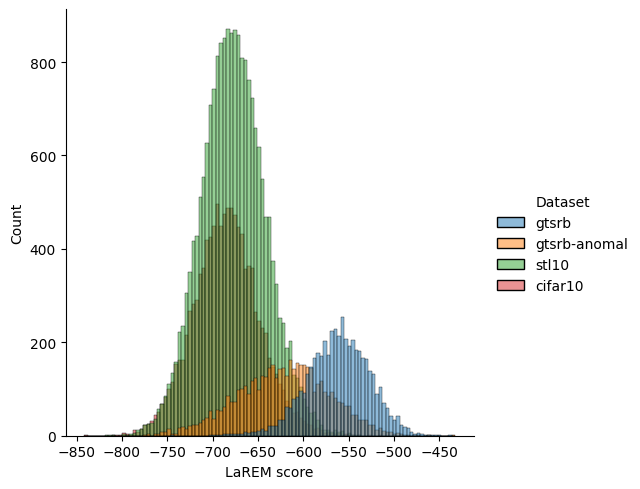

In [59]:
df_larem_scores = pd.concat([df_scores_gtsrb,
                             df_scores_gtsrb_anomal,
                             df_scores_stl10,
                             df_scores_cifar10]).reset_index(drop=True)

sns.displot(df_larem_scores, x="LaREM score", hue="Dataset", kind="hist", fill=True)
plt.show()

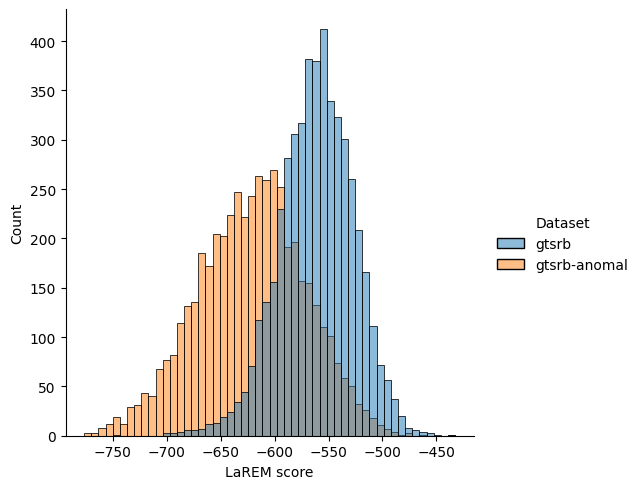

In [61]:
df_larem_scores = pd.concat([df_scores_gtsrb,
                             df_scores_gtsrb_anomal]).reset_index(drop=True)

sns.displot(df_larem_scores, x="LaREM score", hue="Dataset", kind="hist", fill=True)
plt.show()

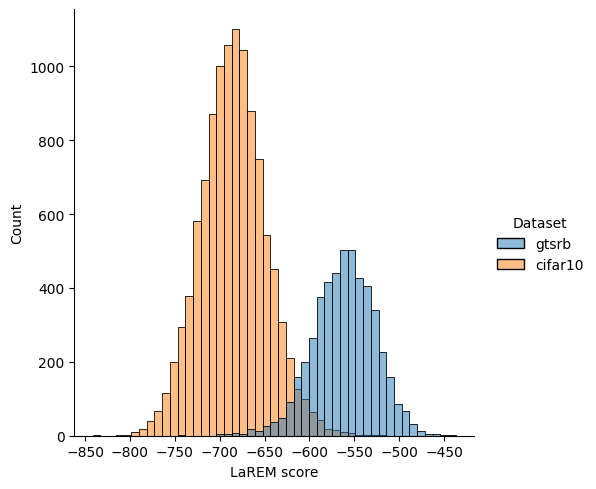

In [63]:
df_larem_scores = pd.concat([df_scores_gtsrb,
                             df_scores_cifar10]).reset_index(drop=True)

sns.displot(df_larem_scores, x="LaREM score", hue="Dataset", kind="hist", fill=True)
plt.show()

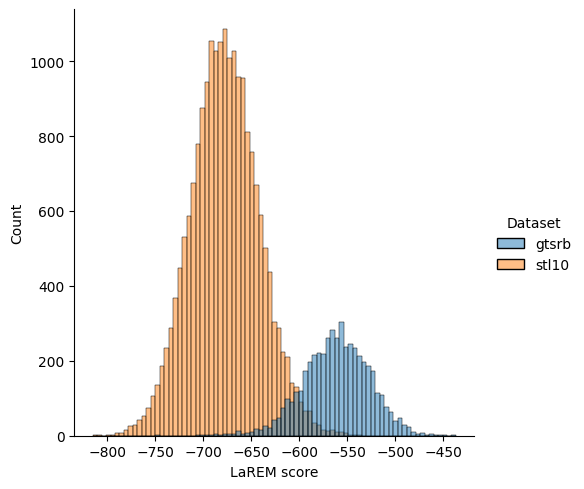

In [64]:
df_larem_scores = pd.concat([df_scores_gtsrb,
                             df_scores_stl10]).reset_index(drop=True)

sns.displot(df_larem_scores, x="LaREM score", hue="Dataset", kind="hist", fill=True)
plt.show()